<a href="https://colab.research.google.com/github/yugpsyfer/Playing_with_PyTorch/blob/main/CNN_CATS%26DOGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats
!unzip test1.zip
!unzip train.zip
!pip install wandb --upgrade

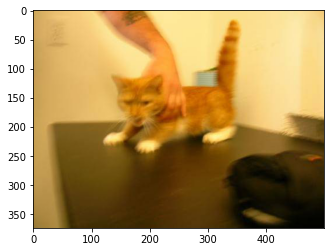

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/content/train/cat.0.jpg')
imgplot = plt.imshow(img)
plt.show()

In [3]:
from torch.utils.data import Dataset
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

class CatsAndDogs(Dataset):
  def __init__(self,root_dir):
    self.root_dir = root_dir
    self.transf = transforms.ToTensor()

  def __len__(self):
    return len(os.listdir(self.root_dir))
  
  def __getitem__(self,index):
    images = os.listdir(self.root_dir)
    with Image.open(self.root_dir+'/'+ images[index]) as im:
      temp = im.resize(size=(100,100),resample=Image.ANTIALIAS)
      Image_Array = self.transf(temp)
      if images[index].split('.')[0] == 'cat':
        label = torch.tensor(data = 0,dtype = int)
      else:
        label = torch.tensor(data = 1,dtype = int)
    
    return (Image_Array,label)

In [4]:
dataSet = CatsAndDogs(root_dir='/content/train')
train_set,test_set = torch.utils.data.random_split(dataSet,[20000,5000])

batch_size=64
train_dl = DataLoader(train_set,batch_size)
val_dl = DataLoader(test_set,batch_size) 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [5]:
import torch
import os
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
class CNN(nn.Module):
  def __init__(self,out_channel=128,nodes=512):
    super().__init__()
    self.cnn_layer_1 = nn.Conv2d(3,out_channels=out_channel,stride=1,kernel_size=3)
    self.pooling_layer = nn.MaxPool2d(2,2)
    self.cnn_layer_2 = nn.Conv2d(out_channel,out_channels=out_channel//2,stride=1,kernel_size=3)
    self.cnn_layer_3 = nn.Conv2d(out_channel//2,out_channels=out_channel//4,stride=1,kernel_size=(3,3))
    self.linear_layer_1 = nn.Linear(3200,nodes)
    self.linear_layer_2 = nn.Linear(nodes,nodes//2)
    self.linear_layer_3 = nn.Linear(nodes//2,2)
    self.flat = nn.Flatten()
  
  def forward(self,xb):
    
    out=self.cnn_layer_1(xb)
    out = F.relu(out)
    out = self.pooling_layer(out)
    out = self.cnn_layer_2(out)
    out = F.relu(out)
    out = self.pooling_layer(out)
    out = self.cnn_layer_3(out)
    out = F.relu(out)
    out = self.pooling_layer(out)

    o = self.flat(out)

    res = self.linear_layer_1(o)
    res = F.relu(res)
    res = self.linear_layer_2(res)
    res = F.relu(res)
    res = self.linear_layer_3(res)

    return res

  def accuracy(self,out,labels):
    _,preds = torch.max(out,dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
  
  def training_step(self,batch):
    images, labels = batch
    images, labels = images.cuda(), labels.cuda()
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = self.accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  @torch.no_grad()
  def evaluate(self,val_loader):
    self.eval()
    outputs = [self.validation_step(batch) for batch in val_loader]
    return outputs

  def fit(self,epochs, lr, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(self.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        self.train()
        # train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss = self.training_step(batch)
            # train_losses.append(loss)
            loss.backward() #BackProp
            optimizer.step()
            
            
        # Validation phase
        if epoch %2 == 0:
          loss_val=0
          acc=0
          dat =  self.evaluate(val_loader)
          for obj in dat:
            loss_val += obj['val_loss'].item()
            acc += obj['val_acc'].item()
          
          loss_val/=len(dat)
          acc/=len(dat)
          wandb.log({"epoch": epoch, "loss": loss_val})
          history.append((loss,acc))
        torch.cuda.empty_cache()
    return history

In [8]:
config = {
    'epochs' : 12,
    'learning_rate' : 0.0001
}

In [ ]:
with wandb.init(project="Cats_and_dogs",config = config):
  ep = wandb.config
  model = CNN()
  train_dl = DeviceDataLoader(train_dl, device)
  val_dl = DeviceDataLoader(val_dl, device)
  to_device(model, device)
  model.fit(ep.epochs,ep.learning_rate,train_dl,val_dl)
  
      
